In [1]:
import sys
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, NearestCentroid
from sklearn.ensemble import  StackingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from functools import partial
from sklearn.model_selection import cross_val_score

d:\miniconda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Training Data preprocessing
with open("data/training_data.txt", "r") as f, open("data/training_data_new.txt", "w") as g:
    for line in f:
        line = line.strip()
        line = ' '.join(line.split())
        g.write(line + "\n")

In [3]:
# load trainging data
data=pd.read_csv('data/training_data_new.txt', sep=' ')

data.drop(data.columns[0], axis=1, inplace=True)

data['activity'] = pd.to_numeric(data['activity'])

data['activity'] = data['activity'].apply(lambda x: x if x <= 7 else 7)

# print(data.head(5))  # print the first 5 rows of the data
print(data['activity'].unique())

[5 7 4 6 1 3 2]


In [4]:
# calculate the class counts
class_counts = data['activity'].value_counts().sort_index()
print("Class counts:")
print(class_counts)

# calculate the class ratios
class_ratios = class_counts / len(data)
print("\nClass ratios:")
print(class_ratios)

# set the threshold for imbalanced dataset
imbalance_threshold = 0.2  # 20% for imbalanced dataset
max_ratio = max(class_ratios)
min_ratio = min(class_ratios)
if (max_ratio - min_ratio) > imbalance_threshold:
    print("\nThe dataset is imbalanced.")
else:
    print("\nThe dataset is balanced.")

Class counts:
1    1226
2    1073
3     987
4    1293
5    1423
6    1413
7     352
Name: activity, dtype: int64

Class ratios:
1    0.157847
2    0.138149
3    0.127076
4    0.166474
5    0.183211
6    0.181924
7    0.045320
Name: activity, dtype: float64

The dataset is balanced.


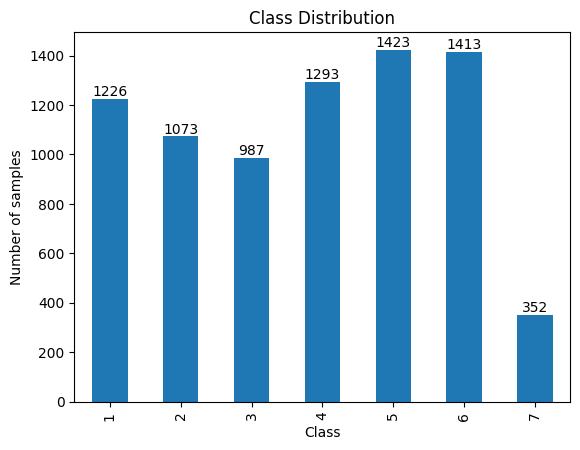

In [5]:
# plot the class distribution
fig, ax = plt.subplots()
class_counts.plot(kind='bar', ax=ax)
ax.set_ylabel('Number of samples')
ax.set_xlabel('Class')
ax.set_title('Class Distribution')

# add the text labels
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

# show the plot
plt.show()

In [6]:
# Spliting training and testing data
X, y = data.iloc[:, 1:], data.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=90)

In [1]:
def objective(trial, X, y, base_learners, meta_learner):
    stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

    # Assign the hyperparameters to be tuned
    stacking_clf.set_params(
                rf__n_estimators=trial.suggest_int('rf__n_estimators', 10, 100),
                rf__max_depth=trial.suggest_categorical('rf__max_depth', [None, 10, 20]),
                svm__C=trial.suggest_float('svm__C', 0.1, 10, log=True),
                svm__kernel=trial.suggest_categorical('svm__kernel', ['linear', 'rbf']),
                ada__n_estimators=trial.suggest_int('ada__n_estimators', 10, 100),
                ada__learning_rate=trial.suggest_float('ada__learning_rate', 0.01, 0.2),
                et__n_estimators=trial.suggest_int('et__n_estimators', 10, 100),
                et__max_depth=trial.suggest_categorical('et__max_depth', [None, 10, 20]),
            )

    # Perform cross-validation
    scores = cross_val_score(stacking_clf, X, y, cv=5, n_jobs=-1)
    return -scores.mean()

# Your callback function
def print_trial_result(trial, total_trials):
    progress = trial.number / total_trials * 100
    print(f'Trial {trial.number} of {total_trials} ({progress:.2f}%): {trial.value:.4f}')
    print(f'Parameters: {trial.params}')
    print('')

In [7]:
# define base learners
base_learners = [
    ('knn', KNeighborsClassifier()),
    ('dt', DecisionTreeClassifier()),
    ('svm', SVC(kernel='linear', probability=True)),
    ('rf', RandomForestClassifier()),
    ('ada', AdaBoostClassifier()),
    ('gnb', GaussianNB()),
    ('et', ExtraTreesClassifier())
]

# define meta learner
meta_learner = LinearSVC()

# create and fit stacking classifier
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# Create a partial function with fixed arguments
objective_func = partial(objective, X=X_train, y=y_train, base_learners=base_learners, meta_learner=meta_learner)

# Total number of trials
n_trials = 10

# Run Optuna optimization
study = optuna.create_study(study_name="Ensemble_Stacking", direction="minimize")
study.optimize(objective_func, n_trials=n_trials, timeout=600, callbacks=[lambda study, trial: print_trial_result(trial, total_trials=n_trials)])
# Print the best parameters
print(f'Best parameters: {study.best_params}')

# Set the best parameters and fit the stacking classifier
stacking_clf.set_params(**study.best_params)
stacking_clf.fit(X_train, y_train)

# Use the best parameters to predict
y_pred = stacking_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

[I 2023-04-14 15:12:58,767] A new study created in memory with name: Ensemble_Stacking
[I 2023-04-14 15:29:34,802] Trial 0 finished with value: -0.9889842632331904 and parameters: {'rf__n_estimators': 47, 'rf__max_depth': 20, 'svm__C': 0.11790290337776048, 'svm__kernel': 'rbf', 'ada__n_estimators': 99, 'ada__learning_rate': 0.011630738096912977, 'et__n_estimators': 94, 'et__max_depth': 20}. Best is trial 0 with value: -0.9889842632331904.


Trial 0 of 10 (0.00%): -0.9890
Trial 0 of 10 (0.00%): -0.9890
Parameters: {'rf__n_estimators': 47, 'rf__max_depth': 20, 'svm__C': 0.11790290337776048, 'svm__kernel': 'rbf', 'ada__n_estimators': 99, 'ada__learning_rate': 0.011630738096912977, 'et__n_estimators': 94, 'et__max_depth': 20}
Parameters: {'rf__n_estimators': 47, 'rf__max_depth': 20, 'svm__C': 0.11790290337776048, 'svm__kernel': 'rbf', 'ada__n_estimators': 99, 'ada__learning_rate': 0.011630738096912977, 'et__n_estimators': 94, 'et__max_depth': 20}


Best parameters: {'rf__n_estimators': 47, 'rf__max_depth': 20, 'svm__C': 0.11790290337776048, 'svm__kernel': 'rbf', 'ada__n_estimators': 99, 'ada__learning_rate': 0.011630738096912977, 'et__n_estimators': 94, 'et__max_depth': 20}
Accuracy: 0.9897039897039897


In [8]:
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("confusion matrix:")
print(cm)

confusion matrix:
[[107   0   0   0   0   0   0]
 [  0 108   0   0   0   0   0]
 [  0   0  92   0   0   0   0]
 [  0   0   0 145   1   0   3]
 [  0   0   0   3 141   0   0]
 [  0   0   0   0   0 135   0]
 [  0   0   0   1   0   0  41]]


In [23]:
# Testing Data preprocessing
with open("data/test_data.txt", "r") as f, open("data/test_data_new.txt", "w") as g:
    for line in f:
        line = line.strip()
        line = ' '.join(line.split())
        g.write(line + "\n")

In [9]:
# load test data
dt=pd.read_csv('data/test_data_new.txt', sep=' ')

dt.drop(dt.columns[0], axis=1, inplace=True)

# print the first row of the data
print(dt.head(1)) 

         F1        F2        F3        F4        F5        F6        F7  \
0  0.030914 -0.008927  0.040382 -0.938504 -0.944626 -0.759334 -0.952398   

         F8        F9       F10  ...     F552      F553      F554      F555  \
0 -0.950281 -0.802483 -0.757099  ...  0.12283 -0.345684 -0.709087  0.006462   

      F556      F557      F558      F559      F560      F561  
0  0.16292 -0.825886  0.271151 -0.720559  0.276779 -0.051074  

[1 rows x 561 columns]


In [10]:
y_new_pred = stacking_clf.predict(dt)

In [11]:
np.savetxt("results/multiclass_re5.txt", y_new_pred,fmt ='%d')

In [ ]:
# Configure logging to output to both file and console
logging.basicConfig(filename='output.log', level=logging.INFO, format='%(message)s')

# Add StreamHandler to output logs to console as well
console_handler = logging.StreamHandler(sys.stdout)
console_handler.setLevel(logging.INFO)
logging.getLogger().addHandler(console_handler)

# define base learners
base_learners = [
    ('knn', KNeighborsClassifier()),
    ('dt', DecisionTreeClassifier()),
    ('svm', SVC(kernel='linear', probability=True)),
    ('rf', RandomForestClassifier()),
    ('ada', AdaBoostClassifier()),
    ('gnb', GaussianNB()),
    ('qda', QuadraticDiscriminantAnalysis()),
]

# define meta learner
meta_learner = LinearSVC()

# create and fit stacking classifier
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# Create a partial function with fixed arguments
objective_func = partial(objective, X=X, y=y, base_learners=base_learners, meta_learner=meta_learner)

# Total number of trials
n_trials = 20

# Run Optuna optimization
study = optuna.create_study(study_name="Ensemble_Stacking", direction="minimize")
study.optimize(objective_func, n_trials=n_trials, timeout=600, callbacks=[lambda study, trial: print_trial_result(trial, total_trials=n_trials)])
# Print the best parameters
print(f'Best parameters: {study.best_params}')

# Set the best parameters and fit the stacking classifier
stacking_clf.set_params(**study.best_params)
stacking_clf.fit(X_train, y_train)

# Use the best parameters to predict
y_pred_out = stacking_clf.predict(dt)
np.savetxt("results/multiclass_re1.txt", y_pred_out,fmt ='%d')

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop

In [7]:
# define merge classes function, transfer 4 and 5 to 1 and 2, and the rest to 0
def merge_classes(y):
    y_new = np.where(y == 4, 1, y)
    y_new = np.where(y == 5, 2, y_new)
    y_new = np.where((y != 4) & (y != 5), 0, y_new)
    return y_new

In [8]:
# change the labels of the training data
y_train_new = merge_classes(y_train)

# change the labels of the testing data
y_test_new = merge_classes(y_test)

# one-hot encoding
y_train_one_hot = to_categorical(y_train_new)
y_test_one_hot = to_categorical(y_test_new)

In [9]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, input_shape=(X_train.shape[1], 1)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(rate=0.5))

model.add(Conv1D(filters=64, kernel_size=3))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(rate=0.5))

model.add(Flatten())

model.add(Dense(units=128))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))

model.add(Dense(units=3, activation='softmax'))

optimizer = RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=0.00001)

# Reshape the input data to have an extra dimension for the channels
X_train_reshaped = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)

history = model.fit(X_train_reshaped, y_train_one_hot, epochs=100, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_one_hot)
print(f"Test accuracy: {test_accuracy:.2f}")

Epoch 1/100
156/156 [==============================] - 17s 86ms/step - loss: 0.5848 - accuracy: 0.7944 - val_loss: 4.5680 - val_accuracy: 0.6597 - lr: 0.0010
Epoch 2/100
156/156 [==============================] - 13s 84ms/step - loss: 0.2535 - accuracy: 0.8944 - val_loss: 3.9205 - val_accuracy: 0.6597 - lr: 0.0010
Epoch 3/100
156/156 [==============================] - 14s 88ms/step - loss: 0.1785 - accuracy: 0.9296 - val_loss: 2.0734 - val_accuracy: 0.6597 - lr: 0.0010
Epoch 4/100
156/156 [==============================] - 13s 84ms/step - loss: 0.1695 - accuracy: 0.9326 - val_loss: 0.2067 - val_accuracy: 0.9131 - lr: 0.0010
Epoch 5/100
156/156 [==============================] - 13s 84ms/step - loss: 0.1326 - accuracy: 0.9435 - val_loss: 0.0869 - val_accuracy: 0.9654 - lr: 0.0010
Epoch 6/100
156/156 [==============================] - 13s 86ms/step - loss: 0.1275 - accuracy: 0.9465 - val_loss: 0.1068 - val_accuracy: 0.9469 - lr: 0.0010
Epoch 7/100
156/156 [==============================]

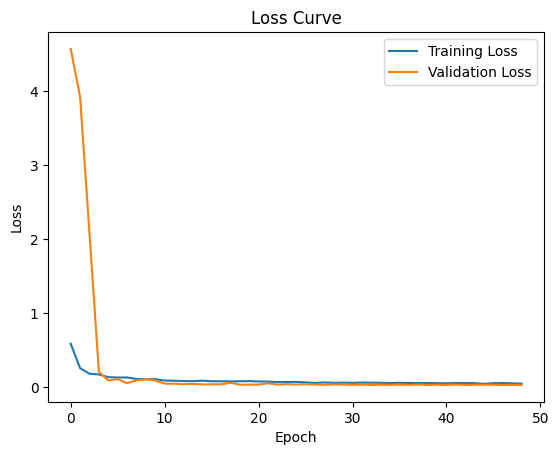

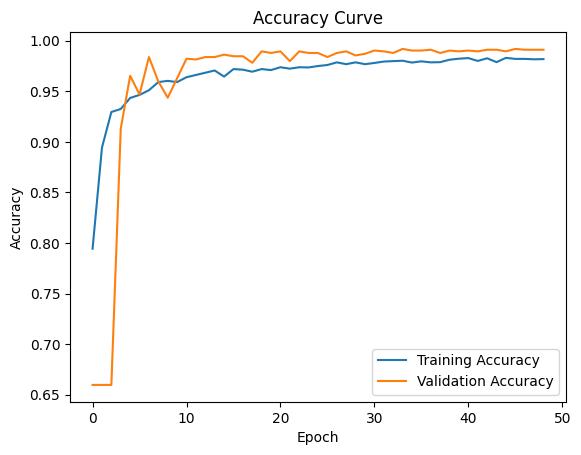

In [10]:
# plot the loss curve and accuracy curve
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

49/49 [==============================] - 1s 11ms/step


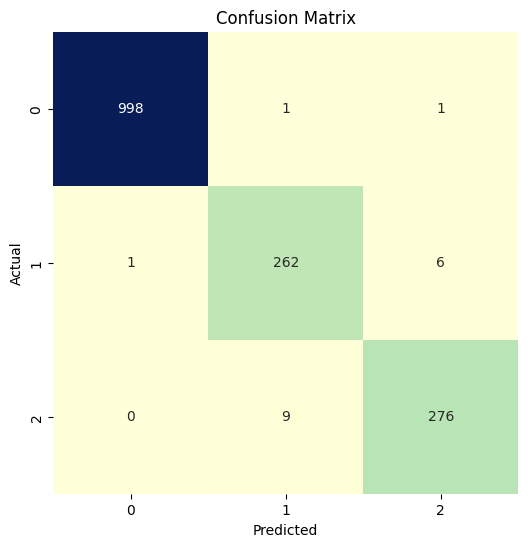

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       0.96      0.97      0.97       269
           2       0.98      0.97      0.97       285

    accuracy                           0.99      1554
   macro avg       0.98      0.98      0.98      1554
weighted avg       0.99      0.99      0.99      1554



In [11]:
y_pred_new = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_new, axis=1)

# calculate confusion matrix
conf_mat = confusion_matrix(y_test_new, y_pred_classes)

# using seaborn to plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", fmt='d', cbar=False, xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# classification report
class_report = classification_report(y_test_new, y_pred_classes)
print("Classification Report:")
print(class_report)

In [31]:
# predict the test dataset
y_test_pred = model.predict(dt)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
np.savetxt("results/multiclass_re2.txt", y_test_pred_classes,fmt ='%d')

99/99 [==============================] - 1s 11ms/step


In [24]:
## Note: the following code is for reproduction, you can skip it if you want to run the code from the beginning
# For reproduction, just load the y_new_pred (ensemble model result) here
y_new_pred=pd.read_csv('results/multiclass_re1.txt', sep=' ', header=None)
print(y_new_pred.head())
print(y_new_pred.shape)

# For reproduction, just load the y_test_pred (CNN model result) here
y_new_pred_cnn=pd.read_csv('results/multiclass_re2.txt', sep=' ', header=None)
print(y_new_pred_cnn.head())
print(y_new_pred_cnn.shape)

   0
0  5
1  5
2  5
3  5
4  5
(3162, 1)
   0
0  5
1  5
2  5
3  5
4  5
(3162, 1)


In [15]:
# For ensemble model result
y_pred_45 = np.where((y_new_pred != 4) & (y_new_pred != 5), 0, y_new_pred)

# For CNN result
y_pred_new_45 = np.where(y_new_pred_cnn == 1, 4, y_new_pred_cnn)
y_pred_new_45 = np.where(y_new_pred_cnn == 2, 5, y_pred_new_45)

print(y_pred_new_45.shape)

(3162, 1)


In [25]:
matching_indices = np.where(y_new_pred == y_new_pred_cnn)
not_matching_indices = np.where(y_new_pred != y_new_pred_cnn)

matching_count = matching_indices[0].size
not_matching_count = not_matching_indices[0].size
print(f"Number of NOT matching indices: {not_matching_count}")
print(f"Number of matching indices: {matching_count}")

Number of NOT matching indices: 85
Number of matching indices: 3077


In [10]:
# Convert the dataframes to numpy arrays
y_new_pred = y_new_pred.values
y_new_pred_cnn = y_new_pred_cnn.values

In [11]:
for i in range(len(y_new_pred)):
    if y_new_pred[i] == 4 and y_new_pred_cnn[i] == 1:
        y_new_pred[i] = 4  
    elif y_new_pred[i] == 5 and y_new_pred_cnn[i] == 2:
        y_new_pred[i] = 5 

print("Combined predictions:", y_new_pred)

Combined predictions: [[5]
 [5]
 [5]
 ...
 [2]
 [2]
 [2]]


In [12]:
np.savetxt("results/multiclass_re5.txt", y_new_pred,fmt ='%d')

In [ ]:
import platform
import importlib

# print the operation system info
os_info = platform.platform()
print(f"OS info: {os_info}")

# print the version of python
python_version = sys.version
print(f"Python version: {python_version}")

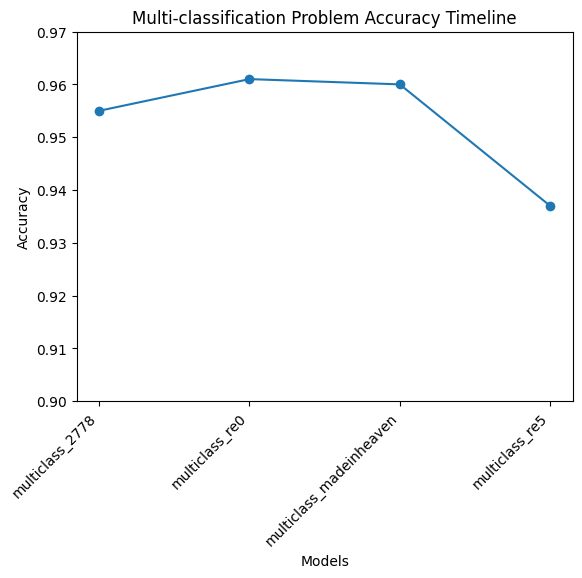

In [2]:
x_labels = ['multiclass_2778', 'multiclass_re0', 'multiclass_madeinheaven', 'multiclass_re5']
y_values = [0.955, 0.961, 0.960, 0.937]
x_indices = np.arange(len(x_labels))

plt.plot(x_indices, y_values, marker='o', linestyle='-')

plt.title('Multi-classification Problem Accuracy Timeline')
plt.xlabel('Models')
plt.ylabel('Accuracy')

plt.ylim(bottom=0.90, top=0.97)

plt.xticks(x_indices, x_labels, rotation=45, ha='right')

plt.show()